# MONAI Components and Features
## What the framework provides for training

### Eric Kerfoot, King's College London, eric.kerfoot@kcl.ac.uk
### MONAI Developers, https://monai.io

* Describe important features of MONAI
* How components fit into the deep learning training workflow
* These include:
  * Data loaders and datasets
  * Data transforms
  * Networks and components
  * Workflow engine classes based on Ignite
* (if you use MONAI already you'll have to bear with me)

### MONAI Training Workflow

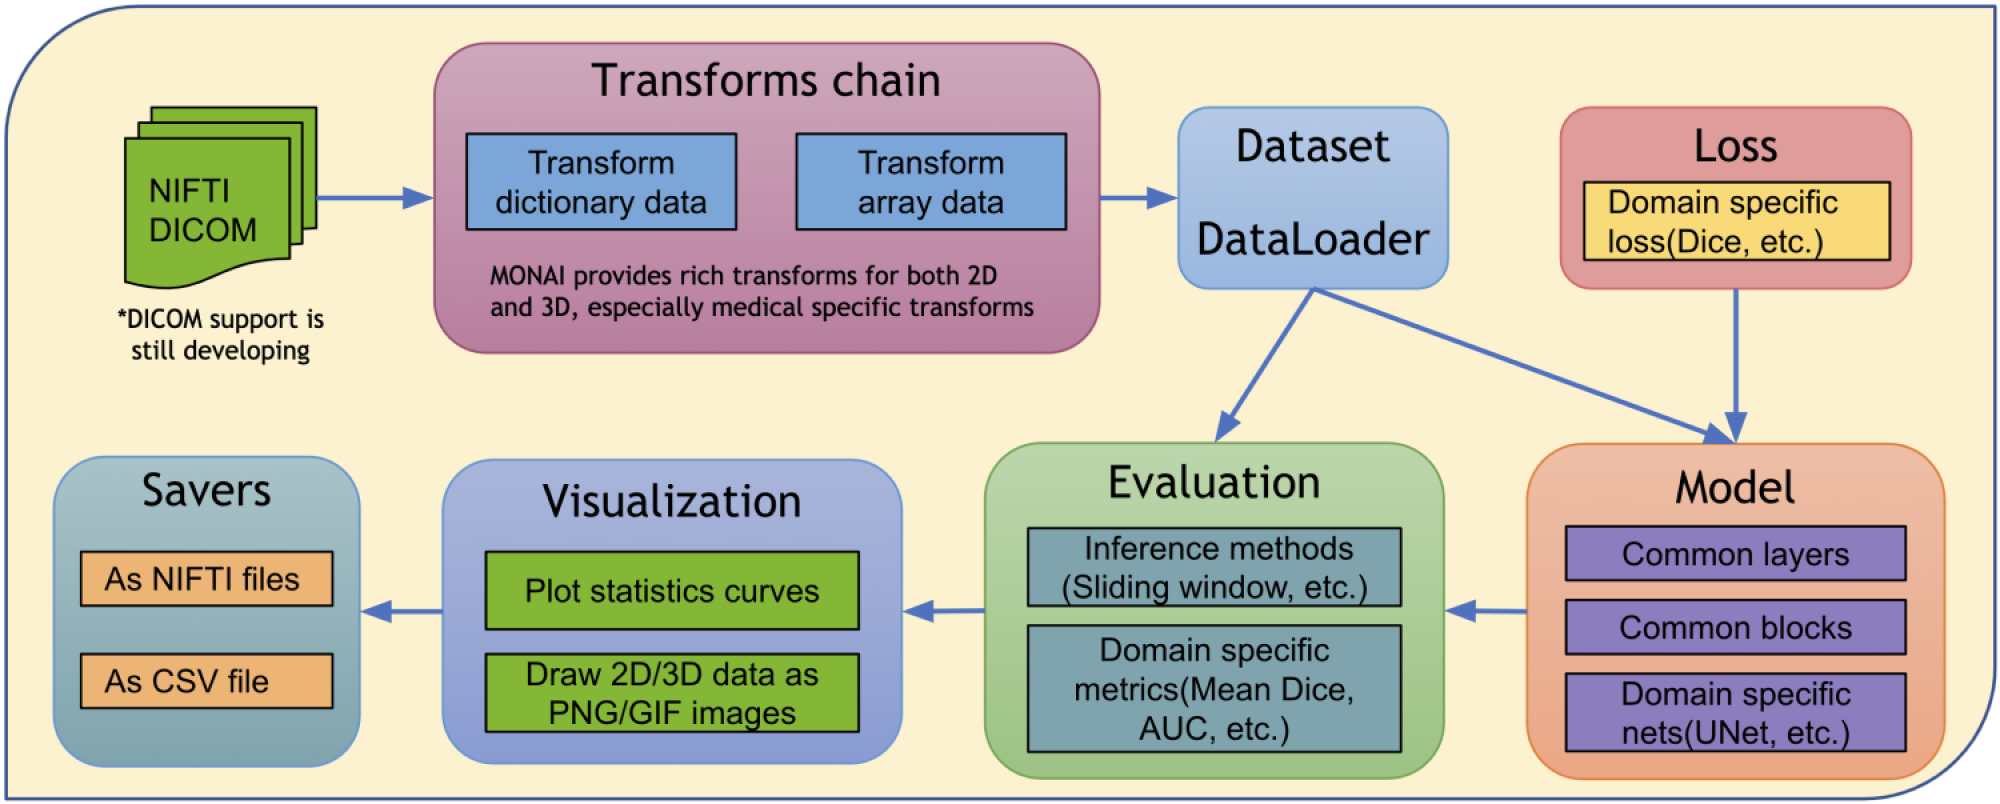

### What's the Need?

* Biomedical applications have specific requirements
* Image modalities (MR, CT, US, etc.) require specific data processing functionality
* Data formats (DICOM, NIfTI, etc.) are specific to medical applications, require support
* Certain network architectures are designed for, or are highly suitable for, biomedical applications
* Data transforms specific to biomedical applications, and to image modalities, are very useful when pre-processing data, augmenting data during training, and for post-processing
* Reproducible science requires reproducible experiments which in turn rely on software accessible to other scientists, such as baseline network implementations and common utilities
* A community-driven library to provide solutions to these requirements reduces duplication/re-implementation

### How Does MONAI Address This Need?

* Direct support for loading and manipulating biomedical file types
* Biomedical-data-specific transforms for regularisation and augmentation of biomedical imaging data for training, validation, and deployment
* Library of general-purpose network, metric, and loss function definitions implementing both established and cutting-edge architectures and features
* Set of ready-made components for training and inference to utilize computing infrastructure efficiently

### Data Loading

* MONAI provides `Dataset` and `DataLoader` classes
* These inherit from those provided by Pytorch
* More advanced `Dataset` classes implement a number of caching strategies
* MONAI also has a custom `DataLoader` class using thread-based concurrency for when processes are not wanted

`Dataset` functions as an indexible list: 

In [19]:
from monai.data import Dataset

items = [{"data": 4}, {"data": 9}, {"data": 3}, 
         {"data": 7}, {"data": 1}, {"data": 2}]
dataset = Dataset(items, transform=None)

print(f"Length of dataset is {len(dataset)}")
for item in dataset:
    print(item)

Length of dataset is 6
{'data': 4}
{'data': 9}
{'data': 3}
{'data': 7}
{'data': 1}
{'data': 2}


* Datasets implement the abstract type from Pytorch
* Add slicing and application of transforms to data
* Compatible with Pytorch `DataLoader`:

In [20]:
import torch
for item in torch.utils.data.DataLoader(dataset, batch_size=2):
    print(item)

{'data': tensor([4, 9])}
{'data': tensor([3, 7])}
{'data': tensor([1, 2])}


* Key feature of `Dataset` and derived classes is the application of transforms to the data on demand
* Typically transforms will load data, standardise data format, apply random data augmentation, and possibly save outputs
* Transforms can be applied to tensor data or to data dictionaries, the latter being much more common
* eg. Converting to tensor:

In [21]:
from monai.transforms import Compose, ToTensord

dataset = Dataset(items, transform=Compose([ToTensord(keys="data")]))
print(dataset[0])

{'data': metatensor(4)}


* The transform sequence `[ToTensord(keys="data")]` is wrapped in a `Compose` object which implements a number of MONAI features
* This callable is called when an item is requested from the `Dataset`
* When this is done, what is loaded, and transforms are applied, are all important optimisation topics
* What `DataLoader` to use is important, default one in MONAI inherits from Pytorch and so uses subprocesses
* Demonstrate with large dataset:

In [4]:
import tempfile
import nibabel as nib
import numpy as np
from monai.data import create_test_image_3d

fn_keys = ("image", "label")  # filename keys for image and seg files

root_dir = tempfile.mkdtemp()
filenames = []

# generate 20 image/segmentation pairs
for i in range(100):
    im, seg = create_test_image_3d(128, 128, 128, num_objs=6, num_seg_classes=2, rad_max=30)

    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"image": im_filename, "label": seg_filename})

    nib.save(nib.Nifti1Image(im, np.eye(4)), im_filename)
    nib.save(nib.Nifti1Image(seg, np.eye(4)), seg_filename)

When an item is indexed the transforms are applied to load the Nifti files, ensure they have a channel dimension, and have their values scaled to the unit range:

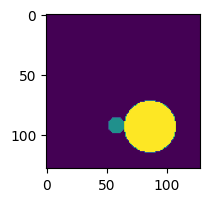

In [22]:
import matplotlib.pyplot as plt
from monai.transforms import LoadImaged, EnsureChannelFirstd, ScaleIntensityd
trans=Compose([
    LoadImaged(keys=fn_keys),  # load data from filenames
    EnsureChannelFirstd(keys=fn_keys),  # adds a 1-sized channel dimension
    ScaleIntensityd(keys=fn_keys)  # ensure image values are in [0,1] range
])

ds = Dataset(filenames, transform=trans)
item=ds[0]
plt.figure(figsize=(2,2))
plt.imshow(item["image"][0,64])

### Transforms

* Callable classes optionally inheriting from `Transform` 
* Can manipulate tensor data or dictionaries of tensors (`MapTransform`)
* Can have randomised behaviour (`Randomizable`) or be deterministic
* MONAI transforms can also be inverted and implement a lazy evaluation alogorithm for combining some operations
* Custom operations can be introduced through wrapper transforms, implementing your own transform, or just including something else callable
* Special dataset classes rely on type however

### DataLoader and Dataset Classes

Loading can be slow:

In [6]:
%time all_items=list(ds)

CPU times: user 26.5 s, sys: 696 ms, total: 27.2 s
Wall time: 21.1 s


Much better off using Pytorch's `DataLoader` classes (inherited by this MONAI type):

In [7]:
import torch
torch.multiprocessing.set_sharing_strategy('file_system')
from monai.data import DataLoader
dl=DataLoader(ds, num_workers=8)

%time all_items=list(dl)

CPU times: user 359 ms, sys: 421 ms, total: 779 ms
Wall time: 2.73 s


* Not always hugely faster, and dependent on number of workers thus number of CPU cores
* Some system settings, such as limits on open file descriptors, cause problems with multiprocessing
* Example used file system sharing to get around memory leak from storing too many items from the data loader
* Multiprocessing can be hard sometimes

* Alternative is to use threads if you don't mind the GIL being in the way
* If most operations are in compiled code this can be efficient
* Can have multiple workers in notebooks on Windows

In [8]:
from monai.data import ThreadDataLoader
dl=ThreadDataLoader(ds, num_workers=8, use_thread_workers=True)

%time all_items=list(dl)

CPU times: user 8.47 s, sys: 2.98 s, total: 11.4 s
Wall time: 2.74 s


### Workflow Classes

* MONAI extends Pytorch Ignite (https://github.com/pytorch/ignite) with classes to define typical workflows
* Instead of writing the same training loop, these can be used to represent the same logic
* Similar to Lightning and other high level frameworks which encapsulate elements of training as object oriented components
* Workflow classes are augmented with handlers which trigger code at specific events, such as doing validation at the end of an epoch or writing to log files
* Postprocessing transforms are applied to raw network outputs for loss functions or storage
* Workflows can be defined to perform just validation or non-training inference

In [23]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.engines import SupervisedTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network = UNet(3,1,3,[8,16,32],[2,2,2]).to(device)
loss = DiceLoss(softmax=True,to_onehot_y=True)

ds = CacheDataset(filenames, transform=trans)
dl = DataLoader(ds,batch_size=6, num_workers=8)

trainer=SupervisedTrainer(
    device=device,
    max_epochs=4,
    train_data_loader=dl,
    network=network,
    optimizer=torch.optim.Adam(network.parameters()),
    loss_function=loss
)

Loading dataset: 100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


This will train our network with the given supervised task (segmentation):

In [24]:
trainer.run()

We can inspect the state afterward to see what the last batch was and the calculated loss:

In [25]:
trainer.state.output[0]["loss"]

0.7069170475006104

* Workflow classes for evaluating network performance are used in conjunction with handlers to trigger when epochs complete, or can be used independently
* Transforms are not needed to convert raw network outputs into a format suitable for metrics, eg. a label map:

In [ ]:
from monai.engines import SupervisedEvaluator
from monai.handlers import MeanDice, from_engine
from monai.transforms import Activationsd, AsDiscreted
    
val_post_transforms=Compose([
    Activationsd(keys="pred", softmax=True),
    AsDiscreted(keys="pred", argmax=True)
])

The engine can then be defined and run:

In [34]:
evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=dl,
    network=network,
    postprocessing=val_post_transforms,
    key_val_metric={
        "val_mean_dice": MeanDice(output_transform=from_engine(["pred", "label"]))
    }
)
evaluator.run()
print(evaluator.state.best_metric)

0.5172501802444458


### Bundles

*  MONAI architecture for packaging network weights with definitions, script files, metadata explaining purpose and use of network
* Defined as a directory structure with a metadata JSON file, JSON/YAML scripts declaring objects to constitute scripts for training, inference etc, documentation files, other scripts, and code
* Used in conjunction with the MONAI model zoo, MONAI Deploy, etc.
* Very useful for distributing your own model as well as training and experiment management
* Tutorials here: https://github.com/Project-MONAI/tutorials/tree/main/bundle

A typical bundle can include:

```
  ModelName
  ┣━ configs
  ┃  ┗━ metadata.json
  ┣━ models
  ┃  ┣━ model.pt
  ┃  ┣━ *model.ts
  ┃  ┗━ *model.onnx
  ┗━ docs
     ┣━ *README.md
     ┗━ *license.txt
```

* Bundle JSON/YAML config scripts are in the `configs` directory
* Saved weights as Torch or Torchscript files stored in `models`
* `scripts` contains custom Python code which can be imported in configs
* `docs` contains all other information and extra content
* MONAI provides programs for running bundles like command line scripts
* Designated JSON (or YAML) scripts will be interpreted and run
* Provides a standard structured approach to including code and description with a model

* The configs for applications are defined as a set of object instantiations and a series of expression to evaluate
* These typically create Ignite-based objects and then train/infer using them and associated definitions
* An example JSON snippet shows how a UNet object can be instantiated:

```json
{
  "network_def": {
    "_target_": "Generator",
    "latent_shape": "@latent_size",
    "start_shape": [64, 8, 8],
    "channels": [32, 16, 8, 1],
    "strides": [2, 2, 2, 1]
  },
}
```

* A YAML snippet of a script creating an evaluator and the `inferring` "program":
```yaml
...
network: $@network_def.to(@device)
...
evaluator:
  _target_: SupervisedEvaluator
  device: '@device'
  val_data_loader: '@dataloader'
  network: '@network'
  inferer: '@inferer'
  postprocessing: '@postprocessing'
```
```yaml
  prepare_batch: '$lambda batchdata, *_,**__: (batchdata.to(@device),None,(),{})'
  val_handlers: '@handlers'
inferring:
- $@evaluator.run()
```

* Much more concepts behind bundles so please refer to documentation
* Model Zoo https://github.com/Project-MONAI/model-zoo has many examples and a few templates for developing your own bundles
* Other MONAI components, such as Deploy, use bundles

### Next: JADE and SLURM